In [82]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

In [87]:
SPLITS = {
    'train': ('2024-01-16', '2024-06-30'),
    'validate': ('2024-07-01', '2024-08-31'), 
    'test': ('2024-09-01', '2025-01-14')
}

split_name = 'train'
# Convert dates to datetime for comparison
split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
split_end = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')

def load_file(filepath):
    """
    Load a CSV file and extract the date (YYYYMMDD from the filename).
    """
    df = pd.read_csv(filepath)
    # Extract the first 8 characters from the filename as the date string.
    file_date = os.path.basename(filepath)[:8]
    # Convert to datetime
    df['date'] = pd.to_datetime(file_date, format='%Y%m%d', errors='coerce')
    return df

def load_split_data(split_name, data_pattern):
    """
    Load and concatenate all CSV files (matching data_pattern) that fall into the
    given split period.
    
    Parameters:
      split_name: 'train', 'validate', or 'test'
      data_pattern: glob pattern (e.g., '/path/to/inference/*.5min.csv')
    
    Returns:
      A concatenated DataFrame.
    """
    split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
    split_end   = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
    
    all_files = glob.glob(data_pattern)
    files_in_split = []
    dfs = []
    for f in all_files:
        try:
            file_date = datetime.strptime(os.path.basename(f)[:8], '%Y%m%d')
        except Exception as e:
            print(f"Error parsing date from {f}: {e}")
            continue
        if split_start <= file_date <= split_end:
            files_in_split.append(f)
            dfs.append(load_file(f))
            
    print(f"Found {len(files_in_split)} files in '{split_name}' period")
    if files_in_split:
        print(f"First file: {files_in_split[0]}")
        print(f"Last file:  {files_in_split[-1]}")
        
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def add_time_features(df):
    """
    Add time-based features from the 'minute' column (assumed format "HH:MM").
    
    Adds:
      - 'hour': integer hour (from the first two characters)
      - 'minute_in_hour': integer minutes (from the characters after ':')
      - 'minutes_from_open': minutes since market open (assumed 9:30)
    """
    df = df.copy()
    # Assume 'minute' is a string "HH:MM"
    df['hour'] = df['minute'].str[:2].astype(int)
    df['minute_in_hour'] = df['minute'].str[3:].astype(int)
    # Calculate minutes from market open (9:30)
    df['minutes_from_open'] = ((df['hour'] - 9) * 60 + df['minute_in_hour'] - 30)
    return df

# =============================================================================
# Missing Data Analysis
# =============================================================================
def analyze_missing_predictions(df):
    """
    Analyze missing predicted values.
    Reports the overall missing percentage, and plots the count of missing
    predictions by hour. Also prints the top 10 symbols with missing predictions.
    """
    missing_mask = df['predicted.volatility'].isna()
    n_missing = missing_mask.sum()
    total = len(df)
    print(f"Overall missing predicted.volatility: {n_missing} out of {total} rows ({100 * n_missing/total:.2f}%)")
    
    # Use the 'hour' column (or recompute it if needed)
    if 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
    missing_by_hour = df[missing_mask].groupby('hour').size()
    
    # Plot a simple bar chart for missing predictions by hour.
    plt.figure(figsize=(8, 4))
    plt.bar(missing_by_hour.index.astype(str), missing_by_hour.values, color='skyblue')
    plt.title("Missing Predictions by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count of Missing Predictions")
    plt.tight_layout()
    plt.show()
    
    # Distribution by symbol
    missing_by_symbol = df[missing_mask].groupby('symbol').size()
    print("\nTop 10 symbols with missing predictions:")
    print(missing_by_symbol.nlargest(10))
    return missing_by_hour, missing_by_symbol

# =============================================================================
# Metrics and Error Analysis
# =============================================================================
def compute_overall_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute overall metrics: RMSE, MAE, Pearson correlation, and Spearman correlation.
    
    Uses only NumPy for correlation calculations.
    """
    valid = df[[target_col, pred_col]].dropna()
    error = valid[pred_col] - valid[target_col]
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(error))
    
    # Pearson correlation using np.corrcoef
    pearson_corr = np.corrcoef(valid[pred_col].values, valid[target_col].values)[0,1]
    # Spearman correlation: compute ranks and then use np.corrcoef
    rank_pred = valid[pred_col].rank().values
    rank_target = valid[target_col].rank().values
    spearman_corr = safe_corrcoef(rank_pred, rank_target)
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr
    }
    print("Overall Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    return metrics

def analyze_predictions(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze predictions versus targets.
    Computes overall RMSE and rank correlations (grouped by date and hour),
    produces a scatter plot and an error histogram, and performs a calibration analysis
    by predicted confidence.
    """
    metrics = compute_overall_metrics(df, target_col, pred_col)
    
    # Compute absolute error and add as a new column.
    df = df.copy()
    df['vol_error'] = np.abs(df[pred_col] - df[target_col])
    
    # Scatter plot: Actual vs. Predicted
    valid = df.dropna(subset=[target_col, pred_col])
    plt.figure(figsize=(8,6))
    plt.scatter(valid[target_col], valid[pred_col], alpha=0.3, color='darkorange')
    plt.plot([valid[target_col].min(), valid[target_col].max()],
             [valid[target_col].min(), valid[target_col].max()], 'r--')
    plt.title("Predicted vs. Actual Volatility")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()
    
    # Histogram of absolute error
    plt.figure(figsize=(8,4))
    plt.hist(df['vol_error'].dropna(), bins=50, color='lightgreen', edgecolor='black')
    plt.title("Distribution of Absolute Error")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Compute metrics by hour of day using NumPy correlations
    hourly_metrics = []
    for hour, group in df.groupby('hour'):
        group_valid = group.dropna(subset=[target_col, pred_col])
        if len(group_valid) == 0:
            continue
        err = group_valid[pred_col] - group_valid[target_col]
        rmse_hour = np.sqrt(np.mean(err**2))
        # Compute Spearman correlation manually:
        rank_pred = group_valid[pred_col].rank().values
        rank_target = group_valid[target_col].rank().values
        if len(rank_pred) > 1:
            corr = np.corrcoef(rank_pred, rank_target)[0,1]
        else:
            corr = np.nan
        hourly_metrics.append((hour, rmse_hour, corr))
    hourly_metrics = np.array(hourly_metrics, dtype=object)
    if hourly_metrics.size:
        hours = [int(x) for x in hourly_metrics[:,0]]
        rmse_vals = [float(x) for x in hourly_metrics[:,1]]
        corr_vals = [float(x) for x in hourly_metrics[:,2]]
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
        ax1.bar([str(h) for h in hours], rmse_vals, color='steelblue')
        ax1.set_title("RMSE by Hour")
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("RMSE")
    
        ax2.bar([str(h) for h in hours], corr_vals, color='salmon')
        ax2.set_title("Spearman Corr by Hour")
        ax2.set_xlabel("Hour")
        ax2.set_ylabel("Spearman Correlation")
        plt.tight_layout()
        plt.show()
    
        metrics['time_of_day'] = {'hours': hours, 'rmse': rmse_vals, 'spearman_corr': corr_vals}
    
    # Confidence calibration: group by quantile of predicted confidence
    if 'predicted.vol_confidence' in df.columns:
        # Drop NAs from predicted confidence before binning.
        conf = df['predicted.vol_confidence'].dropna()
        # Create 10 quantile bins
        quantile_bins = pd.qcut(conf, 10, duplicates='drop')
        calib = df.dropna(subset=['predicted.vol_confidence']).groupby(quantile_bins)['vol_error'].mean()
        # Plot calibration: x-axis is bin labels, y-axis is average error.
        plt.figure(figsize=(10,4))
        plt.bar([str(b) for b in calib.index], calib.values, color='mediumpurple', edgecolor='black')
        plt.xticks(rotation=45, ha='right')
        plt.title("Average Absolute Error by Predicted Confidence Quantile")
        plt.xlabel("Predicted Confidence Quantile")
        plt.ylabel("Average Absolute Error")
        plt.tight_layout()
        plt.show()
        metrics['confidence_calibration'] = calib.to_dict()
    else:
        print("Column 'predicted.vol_confidence' not found; skipping confidence calibration analysis.")
    
    return metrics

# =============================================================================
# Regime, Intraday, and Cross‐Sectional Analysis
# =============================================================================
def analyze_regimes(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Divide data into 5 volatility regimes based on target quantiles,
    and compute RMSE, Spearman correlation (using np.corrcoef on ranks),
    and average predicted confidence for each regime.
    """
    df = df.copy()
    df['vol_regime'] = pd.qcut(df[target_col], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    def regime_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return {'rmse': np.nan, 'spearman_corr': np.nan, 'avg_confidence': np.nan, 'n_obs': len(valid)}
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        avg_conf = valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan
        return {'rmse': rmse_val, 'spearman_corr': spearman_corr, 'avg_confidence': avg_conf, 'n_obs': len(valid)}
    
    regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))
    print("\nRegime Metrics:")
    print(regime_metrics_df)
    # Use pandas built-in plot (which calls matplotlib) for a quick view.
    regime_metrics_df[['rmse', 'spearman_corr']].plot(kind='bar', subplots=True, layout=(1,2), figsize=(14,4), legend=False)
    plt.suptitle("Metrics by Volatility Regime")
    plt.tight_layout()
    plt.show()
    
    return regime_metrics_df


def safe_corrcoef(x, y):
    # Compute standard deviations
    std_x = np.std(x)
    std_y = np.std(y)
    if std_x == 0 or std_y == 0:
        return np.nan
    return np.corrcoef(x, y)[0, 1]


def analyze_intraday_pattern(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze intraday performance by grouping by minute-of-day.
    """
    df = df.copy()
    if 'minute_in_hour' not in df.columns or 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
        df['minute_in_hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.minute
    df['minute_of_day'] = df['hour'] * 60 + df['minute_in_hour']
    
    intraday = df.groupby('minute_of_day').apply(lambda x: pd.Series({
        'rmse': np.sqrt(np.mean((x[pred_col] - x[target_col])**2)),
        'spearman_corr': np.corrcoef(x[pred_col].rank().values, x[target_col].rank().values)[0,1] if len(x) > 1 else np.nan,
        'avg_confidence': x['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in x.columns else np.nan,
        'n_obs': len(x)
    })).reset_index()
    
    plt.figure(figsize=(12,4))
    plt.plot(intraday['minute_of_day'], intraday['rmse'], marker='o', linestyle='-')
    plt.title("Intraday RMSE Pattern")
    plt.xlabel("Minute of Day")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()
    
    return intraday

def compute_symbol_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute per-symbol metrics (RMSE, Pearson and Spearman correlations, etc.)
    using NumPy for correlation computations.
    """
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({
                'rmse': np.nan,
                'pearson_corr': np.nan,
                'spearman_corr': np.nan,
                'avg_confidence': np.nan,
                'avg_vol': np.nan,
                'n_observations': len(valid)
            })
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        pearson = np.corrcoef(valid[pred_col].values, valid[target_col].values)[0,1]
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman = np.corrcoef(rank_pred, rank_target)[0,1]
        avg_conf = valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan
        avg_vol = valid[target_col].mean()
        return pd.Series({
            'rmse': rmse_val,
            'pearson_corr': pearson,
            'spearman_corr': spearman,
            'avg_confidence': avg_conf,
            'avg_vol': avg_vol,
            'n_observations': len(valid)
        })
    cols = ['Y_log_vol_10min_lag_1m', 'predicted.volatility', 'predicted.vol_confidence']
    symbol_metrics = df.groupby('symbol')[cols].apply(compute_metrics)
    return symbol_metrics

# =============================================================================
# Data Quality Checks
# =============================================================================
def check_data_quality(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Print basic data quality statistics and produce a sample time series plot.
    """
    print("Basic Data Checks:")
    print(f"  Total rows: {len(df)}")
    print("  Missing values:")
    print(df[[pred_col, target_col]].isna().sum())
    print("\n  Descriptive Statistics:")
    print(df[[pred_col, target_col]].describe())
    
    # Show a sample of data for the first symbol
    sample_symbol = df['symbol'].iloc[0]
    sample_data = df[df['symbol'] == sample_symbol].head(10)
    print(f"\nSample data for symbol {sample_symbol}:")
    print(sample_data[['minute', pred_col, target_col, 'predicted.vol_confidence']])
    
    # Plot time series for the sample symbol.
    if not sample_data.empty:
        plt.figure(figsize=(10,4))
        plt.plot(sample_data['minute'], sample_data[target_col], label="Actual", marker='o')
        plt.plot(sample_data['minute'], sample_data[pred_col], label="Predicted", linestyle='--', marker='x')
        plt.title(f"Time Series for {sample_symbol}")
        plt.xlabel("Time")
        plt.ylabel("Volatility")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# =============================================================================
# Symbol-Level Performance Analysis
# =============================================================================
def analyze_symbol_performance(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze per-symbol performance after filtering out early market minutes.
    Also apply a simple scaling adjustment so that the prediction mean matches the target mean.
    """
    df = df.copy()
    # Convert 'minute' to datetime if not already done
    df['minute'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce')
    df['hour'] = df['minute'].dt.hour
    df['minute_int'] = df['minute'].dt.minute
    df['minutes_from_open'] = (df['hour'] - 9) * 60 + df['minute_int'] - 30
    
    # Filter out data before 30 minutes after market open
    df_clean = df[df['minutes_from_open'] >= 30].copy()
    
    # Scale predictions: adjust so that the mean prediction equals the mean target
    mean_target = df_clean[target_col].mean()
    mean_pred = df_clean[pred_col].mean()
    if mean_pred != 0:
        df_clean['scaled_pred'] = df_clean[pred_col] * mean_target / mean_pred
    else:
        df_clean['scaled_pred'] = df_clean[pred_col]
    
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({
                'rmse_original': np.nan,
                'rmse_scaled': np.nan,
                'spearman_corr': np.nan,
                'avg_confidence': np.nan,
                'avg_target': np.nan,
                'n_observations': len(valid),
                'n_unique_preds': valid[pred_col].nunique()
            })
        err_orig = valid[pred_col] - valid[target_col]
        err_scaled = valid['scaled_pred'] - valid[target_col]
        rmse_orig = np.sqrt(np.mean(err_orig**2))
        rmse_scaled = np.sqrt(np.mean(err_scaled**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        return pd.Series({
            'rmse_original': rmse_orig,
            'rmse_scaled': rmse_scaled,
            'spearman_corr': spearman_corr,
            'avg_confidence': valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan,
            'avg_target': valid[target_col].mean(),
            'n_observations': len(valid),
            'n_unique_preds': valid[pred_col].nunique()
        })
    
    symbol_perf = df_clean.groupby('symbol').apply(compute_metrics)
    
    print("\nOverall Symbol-Level Performance Summary:")
    print(symbol_perf.describe())
    
    # Plot the distribution of original RMSE across symbols.
    plt.figure(figsize=(8,4))
    plt.hist(symbol_perf['rmse_original'].dropna(), bins=50, color='lightblue', edgecolor='black')
    plt.title("Distribution of Original Symbol-level RMSE")
    plt.xlabel("RMSE")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Print top 10 symbols by Spearman correlation.
    valid_corrs = symbol_perf[symbol_perf['spearman_corr'].notna()]
    if len(valid_corrs) > 0:
        top_symbols = valid_corrs.sort_values('spearman_corr', ascending=False).head(10)
        print("\nTop 10 symbols by Spearman correlation:")
        print(top_symbols[['spearman_corr', 'n_observations', 'n_unique_preds']])
    else:
        print("No valid correlations found.")
    
    return symbol_perf


Found 3 files in 'train' period
First file: /Users/raghuvar/Code/dataBAM/inference/20240118.5min.csv
Last file:  /Users/raghuvar/Code/dataBAM/inference/20240116.5min.csv
Basic Data Checks:
  Total rows: 206251
  Missing values:
predicted.volatility      20298
Y_log_vol_10min_lag_1m        0
dtype: int64

  Descriptive Statistics:
       predicted.volatility  Y_log_vol_10min_lag_1m
count         185953.000000           206251.000000
mean               0.516655                0.000693
std                0.277905                0.001002
min               -0.036438                0.000000
25%                0.322754                0.000323
50%                0.447998                0.000499
75%                0.708984                0.000803
max                1.662109                0.175946

Sample data for symbol A:
  minute  predicted.volatility  Y_log_vol_10min_lag_1m  \
0  09:35                   NaN                0.001769   
1  09:40                   NaN                0.001808   

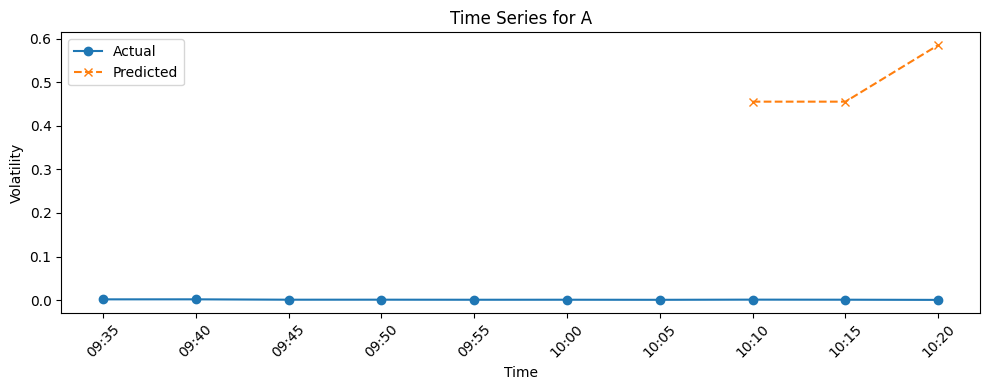

Overall missing predicted.volatility: 20298 out of 206251 rows (9.84%)


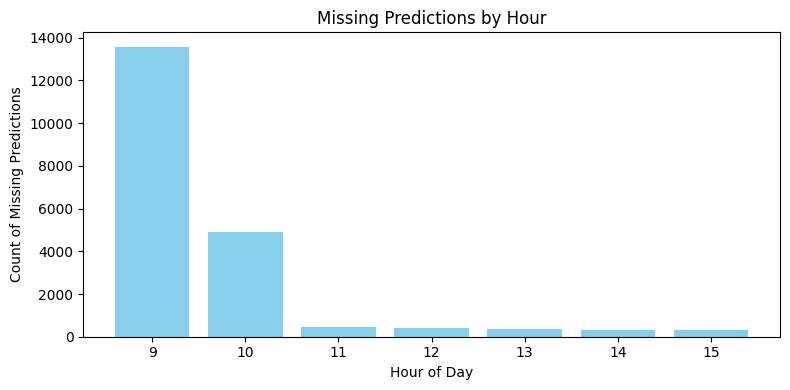


Top 10 symbols with missing predictions:
symbol
SQQQ    225
SOXS    214
EEM     207
FXI     203
ITUB    198
SPXS    161
SPXU    159
QID     115
SHY     107
BIL     102
dtype: int64
Overall Metrics:
  rmse: 0.5861
  mae: 0.5165
  pearson_corr: 0.0212
  spearman_corr: 0.0835


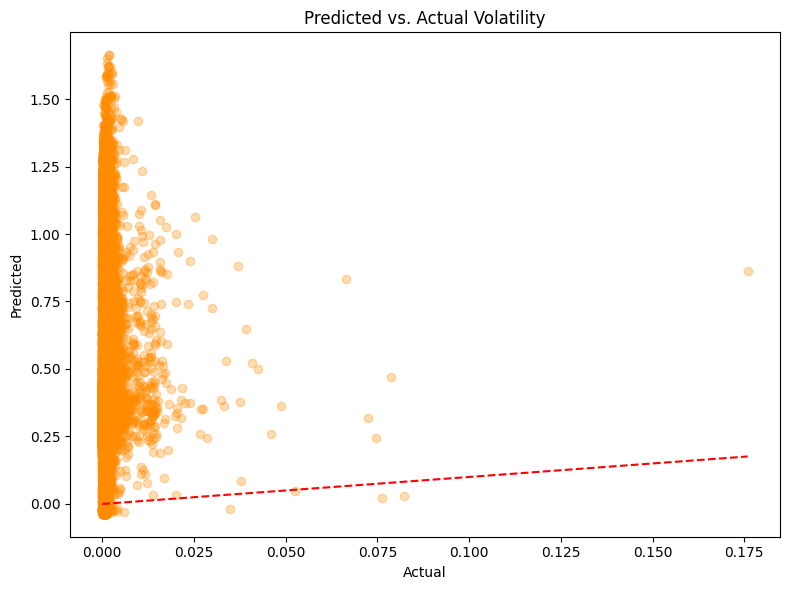

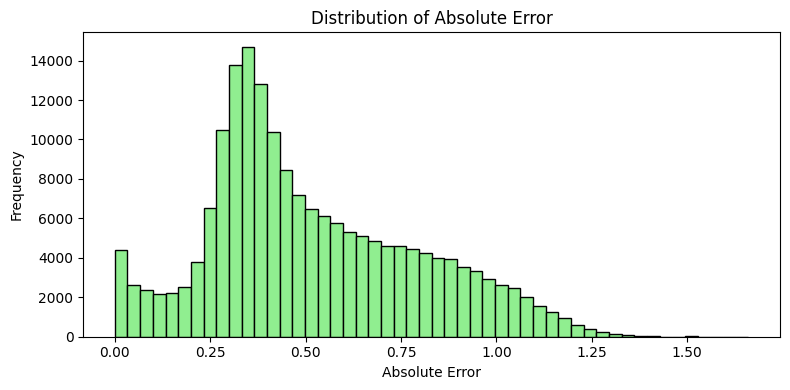

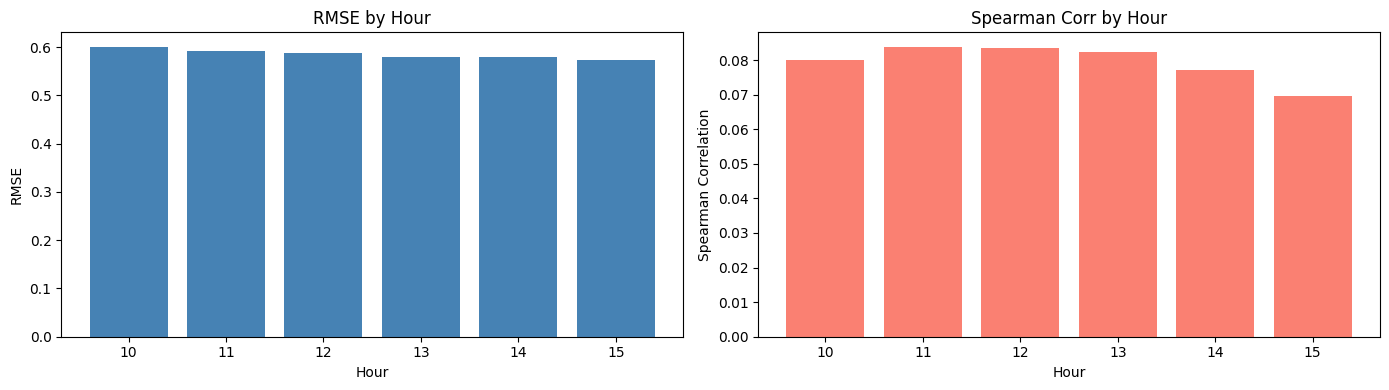

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_81165/1097065392.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.dropna(subset=['predicted.vol_confidence']).groupby(quantile_bins)['vol_error'].mean()


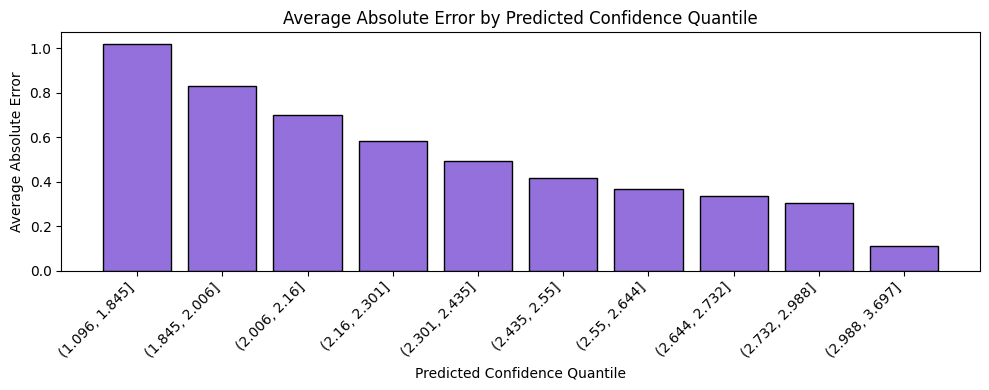

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_81165/1097065392.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_81165/1097065392.py:259: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))



Regime Metrics:
                rmse  spearman_corr  avg_confidence    n_obs
vol_regime                                                  
Very Low    0.545918       0.120398        2.486190  39663.0
Low         0.592880       0.016682        2.434254  40169.0
Medium      0.599672       0.010443        2.410835  39474.0
High        0.597037       0.001876        2.397642  36909.0
Very High   0.596576      -0.031191        2.360320  29738.0


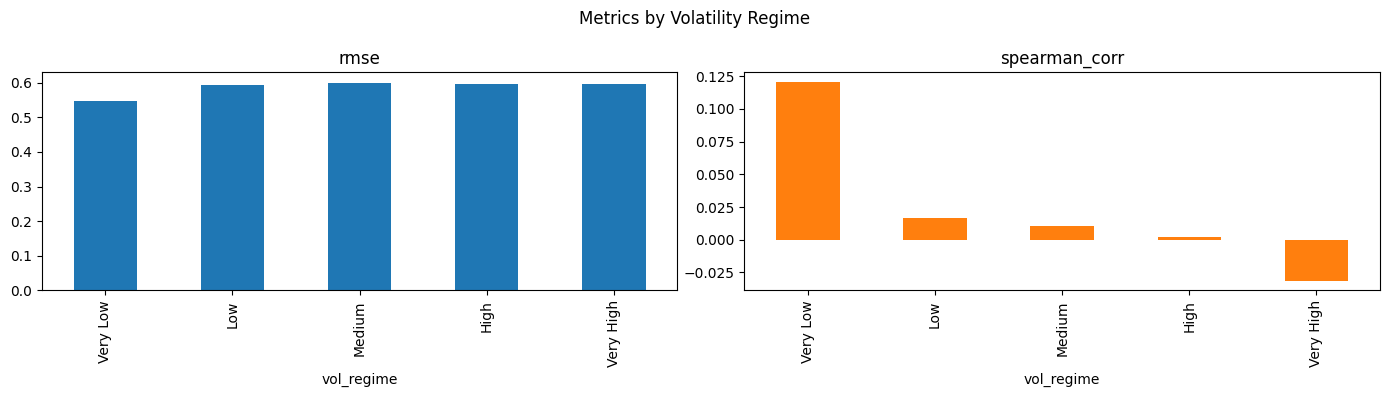

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_81165/1097065392.py:290: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  intraday = df.groupby('minute_of_day').apply(lambda x: pd.Series({


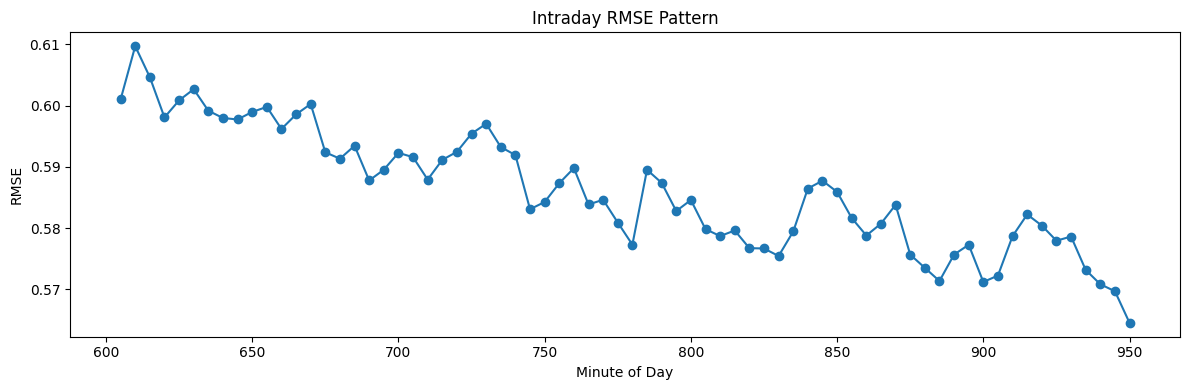

/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Overall Symbol-Level Performance Summary:
       rmse_original  rmse_scaled  spearman_corr  avg_confidence   avg_target  \
count    1005.000000  1005.000000    1004.000000     1005.000000  1005.000000   
mean        0.529652     0.000707       0.041785        2.431011     0.000630   
std         0.243202     0.000817       0.141203        0.380449     0.000475   
min         0.013788     0.000125      -0.362597        1.725660     0.000002   
25%         0.355381     0.000352      -0.051375        2.101304     0.000409   
50%         0.463556     0.000530       0.042761        2.457771     0.000529   
75%         0.761819     0.000782       0.135743        2.609019     0.000719   
max         1.051203     0.012392       0.584156        3.543820     0.010130   

       n_observations  n_unique_preds  
count     1017.000000     1017.000000  
mean       182.844641       87.824975  
std         39.502460       20.089731  
min          0.000000        0.000000  
25%        175.000000      

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_81165/1097065392.py:431: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  symbol_perf = df_clean.groupby('symbol').apply(compute_metrics)


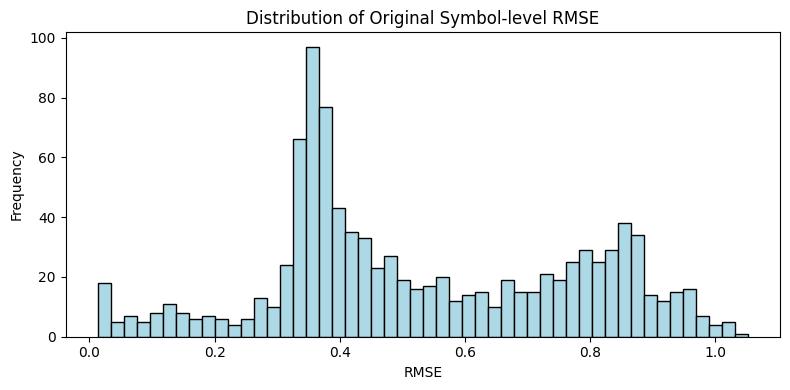


Top 10 symbols by Spearman correlation:
        spearman_corr  n_observations  n_unique_preds
symbol                                               
HUM          0.584156           205.0           100.0
FERG         0.488197           182.0            88.0
ANSS         0.473702           206.0            97.0
RACE         0.465862           123.0            63.0
CART         0.451594            69.0            34.0
ELF          0.434275           184.0            90.0
XOP          0.422967           210.0           100.0
MCHP         0.399583           210.0           102.0
AEP          0.372942           210.0           103.0
BURL         0.369961           184.0            90.0

Overall Metrics:
{'rmse': 0.5860918306431632, 'mae': 0.5165122807196949, 'pearson_corr': 0.021236548930327497, 'spearman_corr': 0.08352050594864315, 'time_of_day': {'hours': [10, 11, 12, 13, 14, 15], 'rmse': [0.6008823002036346, 0.5927499369058423, 0.5887262048068161, 0.5806331382782549, 0.5798653649726064, 0

In [88]:
# Adjust this path to your inference CSV files.
data_pattern = '/Users/raghuvar/Code/dataBAM/inference/*.5min.csv'
split_name = 'train'  # Choose 'train', 'validate', or 'test'

# Load data for the chosen split.
df = load_split_data(split_name, data_pattern)
if df.empty:
    raise ValueError("No data loaded. Check your file paths and date ranges.")

# Add time features.
df = add_time_features(df)

# Perform basic data quality checks.
check_data_quality(df)

# Analyze missing predictions.
analyze_missing_predictions(df)

# Compute and display overall prediction metrics and generate plots.
overall_metrics = analyze_predictions(df)

# Analyze performance across volatility regimes.
regime_metrics = analyze_regimes(df)

# Analyze intraday error patterns.
intraday_metrics = analyze_intraday_pattern(df)

# Compute cross-sectional (symbol-level) metrics.
symbol_metrics = compute_symbol_metrics(df)

# Analyze symbol-level performance with scaling adjustment.
symbol_perf = analyze_symbol_performance(df)

# Optionally, save the summaries to CSV files.
symbol_metrics.to_csv("symbol_metrics_summary.csv", index=True)
symbol_perf.to_csv("symbol_performance.csv", index=True)

# Print final summaries.
print("\nOverall Metrics:")
print(overall_metrics)
print("\nRegime Metrics:")
print(regime_metrics)
print("\nIntraday Metrics (first 10 rows):")
print(intraday_metrics.head(10))
print("\nTop 10 Symbols by Spearman Correlation:")
print(symbol_perf.sort_values('spearman_corr', ascending=False).head(10)[['spearman_corr', 'n_observations', 'n_unique_preds']])